In [1]:
!pip install admmsolver


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
# Download data for G(tau) and rhow(omega) from GitHub repo
from urllib.request import urlretrieve
base_url = "https://raw.githubusercontent.com/SpM-lab/SpM/master/samples/fermion/"
for name in ["Gtau.in", "Gtau.in.dos"]:
    urlretrieve(base_url + name, name)
# Alternatively, we can use the following command:
#!wget https://raw.githubusercontent.com/SpM-lab/SpM/master/samples/fermion/Gtau.in
#!wget https://raw.githubusercontent.com/SpM-lab/SpM/master/samples/fermion/Gtau.in.dos

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
#Load Gtau
Gtau = np.loadtxt("Gtau.in")[:, 2]

# Set imaginary-time
beta = 100
ntau = len(Gtau)
ts = np.linspace(0.0, beta, ntau)

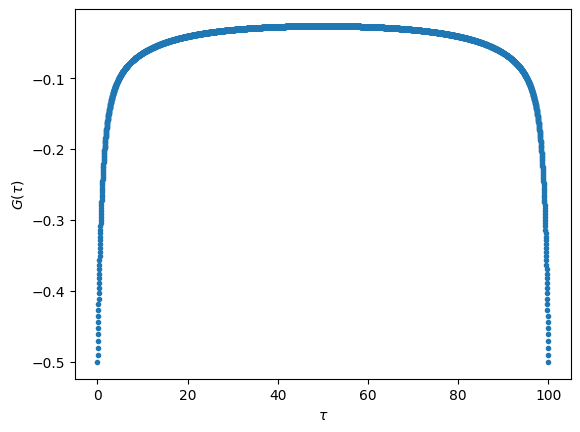

In [5]:
# Plot G(tau)
fig, ax = plt.subplots()
ax.plot(ts, Gtau, '.')
ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$G(\tau)$")
plt.show()

In [6]:
#Set omega
Nomega = 1001
omegamin = -4
omegamax = 4
ws = np.linspace(-omegamax, omegamax, num=Nomega)

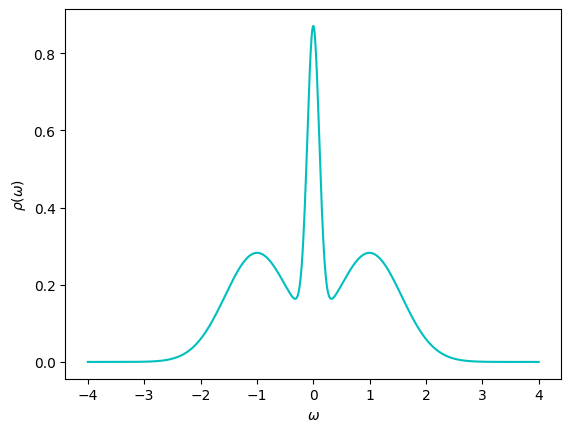

In [7]:
rho_answer = np.loadtxt("Gtau.in.dos")[:, 1]

# Plot rho(omega)
fig, ax = plt.subplots()
ax.plot(ws, rho_answer, '-c')
ax.set_xlabel(r"$\omega$")
ax.set_ylabel(r"$\rho(\omega)$")
plt.show()

In [8]:
import sparse_ir

#Set basis
SVmin = 1e-10
basis = sparse_ir.FiniteTempBasis(
            statistics="F", beta=beta, wmax=omegamax, eps=SVmin
        )
U = basis.u(ts).T
S = basis.s
V = basis.v(ws).T

In [9]:
print(f"{U.shape}, {S.shape}, {V.shape}")

(4001, 43), (43,), (1001, 43)

In [10]:
y = -Gtau
A = np.einsum("il,l->il", U, S)

In [11]:
import admmsolver
import admmsolver.optimizer
import admmsolver.objectivefunc
from admmsolver.objectivefunc import (
    L1Regularizer,
    #LeastSquares,
    ConstrainedLeastSquares,
    NonNegativePenalty,
)
from admmsolver.matrix import identity
from admmsolver.optimizer import SimpleOptimizer
print(f"admmsolver=={admmsolver.__version__}")

admmsolver==0.7.7

In [12]:
# sum-rule
rho_sum = y[0] + y[-1]
C = (A[0] + A[-1]).reshape(1, -1)
lstsq_F = ConstrainedLeastSquares(0.5, A=A, y=y, C=C, D=np.array([rho_sum]))

In [13]:
lambda_ = 10**-1.8  # regularization parameter
l1_F = L1Regularizer(lambda_, basis.size)

In [14]:
nonneg_F = NonNegativePenalty(Nomega)

In [15]:
objective_functions = [lstsq_F, l1_F, nonneg_F]
equality_conditions = [
    (0, 1, identity(basis.size), identity(basis.size)),
    # (0, 2, V.T, identity(Nomega)),
    (0, 2, V, identity(Nomega)),
]

p = admmsolver.optimizer.Problem(objective_functions, equality_conditions)

In [16]:
maxiteration = 1000
initial_mu = 1.0
opt = SimpleOptimizer(p, mu=initial_mu)  # initialize solver
opt.solve(maxiteration)  # solve

In [17]:
x0, x1, x2 = opt.x
print(f"{x0.shape}, {x1.shape}, {x2.shape}")

(43,), (43,), (1001,)

In [18]:
rho = V @ x0

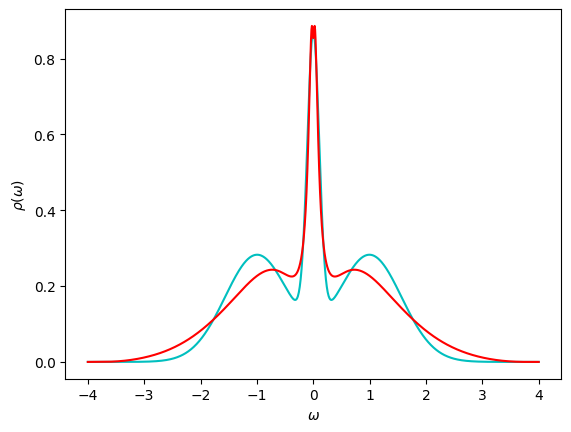

In [19]:
fig, ax = plt.subplots()
ax.plot(ws, rho_answer, '-c')
ax.plot(ws, rho.real, '-r')
ax.set_xlabel(r"$\omega$")
ax.set_ylabel(r"$\rho(\omega)$")
plt.show()

In [20]:
# save results
# specfile = "spectrum.dat"
# with open(specfile, "w") as f:
#     f.write(f"# log_lambda = f{lambdalog}\n")
#     for w, r in zip(ws, rho):
#         f.write(f"{w} {np.real(r)}\n")